### Data Generation Notebook

This notebook generates data helpful to test the model we're building for the lab.

The create_instance function will calculate a score from a number of attributes related to the loan request.  If the score reaches a certain threshold then the loan is approved.

In [1]:
import numpy as np

def create_instances(number_of_instances):
    
    makes = [("Ford",3),("GM",2),("VW",5),("Toyota",10),("Porsche",9)]
    models = dict()
    models["Ford"] = [("Escape","SUV"), ("Focus","Car")]
    models["GM"] = [("Malibu","Car"), ("Volt","Car")]
    models["VW"] = [("Golf","Car"), ("Atlas","SUV")]
    models["Toyota"] = [("Corolla","Car"), ("4Runner","SUV")]
    models["Porsche"] = [("911","Car"), ("Cayenne","SUV")]
    
    result = []
    for i in range(number_of_instances):
        
        makesEntry = makes[np.random.randint(5)]
        make = makesEntry[0]
        modelEntry = models[make][np.random.randint(2)]
        model = modelEntry[0]
        vType = modelEntry[1]
        
        year = np.random.randint(1990,2018)
        
        requestedAmount = np.random.randint(1000,34000)
        approvedAmount = 0
        creditScore = np.random.randint(50,1000)
        
        makeScore = makesEntry[1] / 10
        
        typeScore = 0
        if(vType == 'SUV'):
            typeScore += 1
        
        
        
        if(requestedAmount > 15000):
            amountScore = 0
        elif(requestedAmount > 10000):
            amountScore = 3
        elif(requestedAmount > 5000):
            amountScore = 6
        else:
            amountScore = 10
        
        amountScore /= 10
        
        age = 2018 - year
        
        ageScore = 0
        if(age == 0):
            ageScore += 10
        elif (age <= 3):
            ageScore += 8
        elif (age <=7):
            ageScore += 6
        elif (age <= 10):
            ageScore += 3
        
        ageScore /= 10
        
        credit = 0
        if(creditScore > 300):
            credit += 3
        elif (creditScore > 500):
            credit += 6
        elif (creditScore > 700):
            credit += 10
        
        credit /= 10
        
        finalScore = (makeScore * 0.1 + typeScore * 0.1 +  amountScore * 0.30 + ageScore * 0.2 + credit * 0.3) * 100
        
        if(finalScore > 100 or finalScore < 0):
            raise ValueError('Final Score corrupt: ' + finalScore)
        
        approved = "false"
        if(finalScore > 40):
            approved = "true"
            
        
        # Introduce some random behvaiour into the decision
        reverse = np.random.randint(1,10)
        resultReversed = "false"
        if(reverse == 1):  # Reverse the result 10% of the time
            if(approved == "true"): 
                approved = "false"
            else:
                approved = "true"
            resultReversed = "true"
            
        if(approved == "true"):
            approvedAmount = requestedAmount
        
        entry = {"id": " e488e5132f5f2161792162189", 
            "offset": 314, 
            "partition": 0, 
            "bpmCellName": "bpmCell01", 
            "version": "0.1.0", 
            "type": "EVENT_THROWN", 
            "timestamp": "2018-01-12T15:06:34.491+01:00", 
            "activityId": "bpdid:431b0753c33842e2:3d5457c0:141a2fd3448:-75fb", 
            "activityVersionId": "2064.f1659d94-2365-4903-8a90-9fa62f3ccd31", 
            "activityName": "Claim approval", 
            "activityType": "userTask", 
            "processApplicationVersionId": "2064.3a3ebfc4-da8a-4d09-9359-8f33003c2f83", 
            "processApplicationSnapshotName": "Reco service Sample v8600_01", 
            "processApplicationName": "Recommendation service", 
            "processApplicationId": "2066.f8adcf19-53a9-4fc2-b1f8-637fe94483c2 ", 
            "activityInstanceId": "processId.bpmSystemId.processInstanceId.taskInstanceId", 
            "processInstanceId": "processId.bpmSystemId.processInstanceId", 
            "parentId": "processId.bpmSystemId.processInstanceId[.parentTaskInstanceId]", 
            "trackedFields": {
                "vehicleMake.string": make, 
                "vehicleType.string": vType, 
                "vehicleModel.string": model, 
                "vehicleYear.integer": year, 
                "approvedAmount.integer": approvedAmount, 
                "requestedAmount.integer": requestedAmount, 
                "creditScore.integer": creditScore,
                "score.integer": finalScore,  # track this to check the data
                "approved.string": approved, 
                "wasReversed.string": resultReversed # track this to check the data
            }, 
            "trackingGroupName": "Loan_Approval", 
            "trackingPointName": "Tracking", 
            "trackingPointId": "-f4ed8784d4a8bpdid431b0753c33842e23d5457c0141a2fd3448-75fb (PRE)", 
            "trackingGroupId": "fb6ebad8-ddec-492c-8ed4-f26b362c99ea", 
            "trackingGroupVersionId": "2064.f1659d94-2365-4903-8a90-9fa62f3ccd31", 
            "trackingPointVersionId": "2064.f1659d94-2365-4903-8a90-9fa62f3ccd31", 
            "trackingPointOccurrenceTime": "2018-01-12T15:06:34.494+01:00", 
            "kpiData": { }, 
            "bpmSystemId": "47a21c0d-7af5-4d6c-bac6-7ecbec83a961", 
            "sequenceId": 6, 
            "performerName": "bpmadmin", 
            "performerId": "bpmadmin"
        }
        result.append(entry)
    
    return result



Call the function above to create the sample data.  We save it to a json file that we can consume later.  The format of the data matches what BAI drops into HDFS.  We don't worry about the process app ID or the process itself as that part is discarded.  We only care about what's in the trackedFields element which carries the actual business data.

In [2]:
from pyspark.sql import  SparkSession
import pandas as pd

sampleDataSet = create_instances(20000)

sampleDataSetFile = open("sample_loan_approval.json","w", encoding="UTF-8")
sampleDataSetFile.write(str(sampleDataSet))
sampleDataSetFile.close()

spark = SparkSession.builder.getOrCreate()
summaries = spark.read.json("sample_loan_approval.json")  

summaries.createOrReplaceTempView("timeseries")

businessdata = spark.sql("SELECT trackedFields.* from timeseries")

summary_pd = businessdata.toPandas()

print(summary_pd.columns)

Index(['approved.string', 'approvedAmount.integer', 'creditScore.integer',
       'requestedAmount.integer', 'score.integer', 'vehicleMake.string',
       'vehicleModel.string', 'vehicleType.string', 'vehicleYear.integer',
       'wasReversed.string'],
      dtype='object')


### Verify the Data

Let's examine the data that was generated.

In [3]:
print(summary_pd.columns)

Index(['approved.string', 'approvedAmount.integer', 'creditScore.integer',
       'requestedAmount.integer', 'score.integer', 'vehicleMake.string',
       'vehicleModel.string', 'vehicleType.string', 'vehicleYear.integer',
       'wasReversed.string'],
      dtype='object')


Let's describe the numeric data.

In [4]:
summary_pd.describe()   

,approvedAmount.integer,creditScore.integer,requestedAmount.integer,score.integer,vehicleYear.integer
count,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000
mean,3049.633650,526.14860,17541.606300,28.175700,2003.483050
std,6973.553526,275.19883,9541.227102,14.268378,8.127928
min,0.000000,50.00000,1005.000000,2.000000,1990.000000
25%,0.000000,290.00000,9231.250000,18.000000,1996.000000
50%,0.000000,526.00000,17506.500000,27.000000,2003.000000
75%,1778.000000,765.00000,25846.250000,37.000000,2011.000000
max,33988.000000,999.00000,33997.000000,75.000000,2017.000000


Let's look at the distribution of values for a particular column.

In [5]:
summary_pd['approved.string'].value_counts()

false    14624
true      5376
Name: approved.string, dtype: int64

Let's see some plots of the data. We import the matplotlib to do this.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


First we plot pairwise relationships in our dataset.  This allows us to see visually if there is any correlation between values as we would expect.  We see that the score column has either a negative or positive correlation with all the features that we use to calculate it.  So this is good.

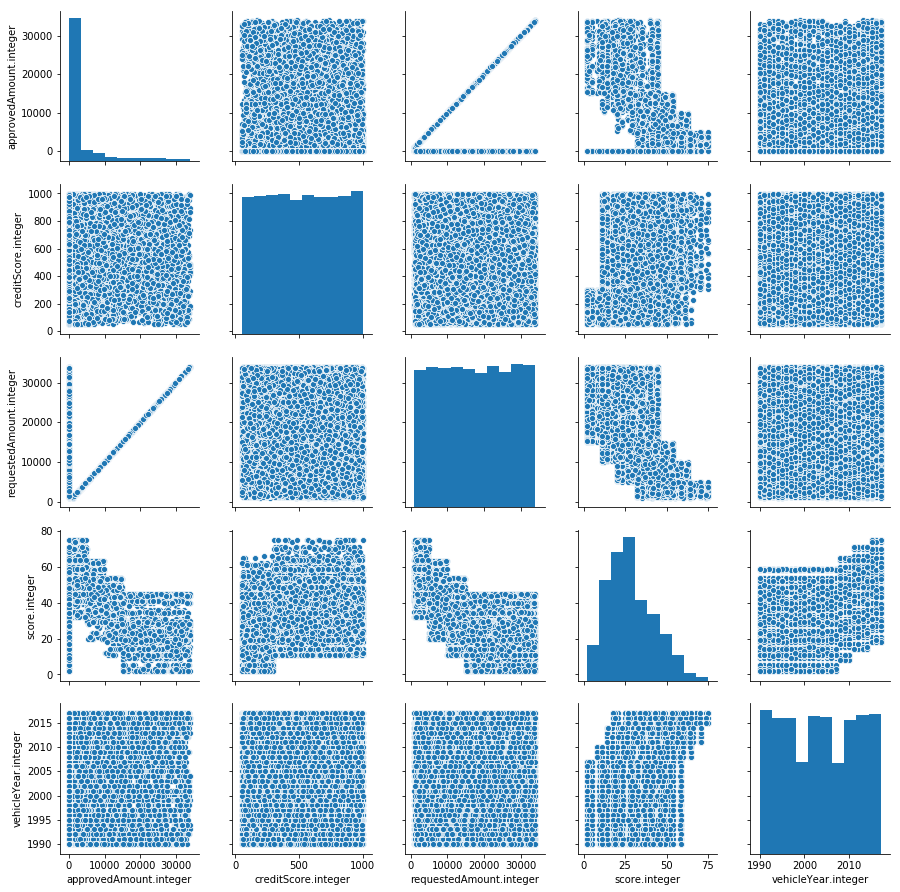

In [7]:
sns.pairplot(summary_pd)

The approved column is not numerical so it does not show up in the plots above.  To make sure we have enough of a different distribution of approved versus denied for our scores we use a box plot.  We confirm there is minimal to no overlap so the data should be good enough to produce a model that gives an accurate prediction.

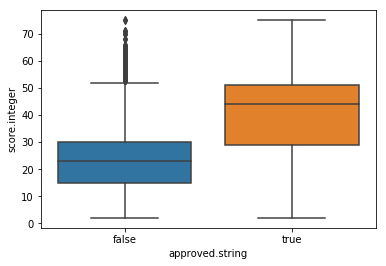

In [8]:
sns.boxplot(x="approved.string", y="score.integer", data=summary_pd)